# 강화학습(Reinforce Learning, RL)

https://dacon.io/competitions/official/236592/overview/description

## 1. 환경(Environment)
- 미로 자체가 **환경**이다.  
- 환경은 상태(state), 행동(action), 보상(reward) 규칙으로 정의된다.
  - **상태**: 에이전트의 현재 위치·방향(또는 시야 이미지).  
  - **행동**: 위/아래/좌/우 이동, 회전, 전진 등.  
  - **보상**: 목표 지점 도달 시 +1, 그 외 대부분 0, 잘못된 행동이나 시간 초과 시 0 또는 -1.  

## 2. 에이전트(Agent)
- 에이전트는 정책(policy)이라는 함수를 따라 행동을 선택한다.  
- 정책은 단순한 표(탭형 Q-table)일 수도 있고, 신경망(Deep Q-Network, PPO 등)일 수도 있다.  

## 3. 목표(Goal)
- 목표는 **최단 시간에 목표 지점까지 도달**하는 것.  
- 에피소드마다 시작 위치·목표 위치가 바뀔 수 있어, 일반화된 경로 찾기 전략을 학습해야 한다.  

## 4. 학습 과정
1. **탐험(Exploration)**  
   - 처음에는 미로 구조를 모르기 때문에 무작위로 움직이며 경험을 쌓는다.
2. **경험 누적**  
   - (상태, 행동, 보상, 다음 상태)의 경험을 저장.  
3. **정책 개선**  
   - Q-러닝:\
$[Q(s,a) ← Q(s,a) + \alpha \big(r + \gamma \max_{a'} Q(s',a') - Q(s,a)\big)]$
로 Q값 업데이트.  
   - 딥RL(PPO, DQN 등):\
신경망을 통해 정책/가치 함수를 근사하고, 보상 합계(리턴)를 극대화하도록 파라미터 조정.  
4. **성공 확률 증가**  
   - 시간이 지날수록 무작위보다는 목표로 가는 경로를 더 자주 선택.  

## 5. 중요 개념
- **에피소드(Episode)**: 시작~목표 도달 or 최대 스텝 종료까지의 한 판.  
- **보상 설계(Reward shaping)**: 희소 보상(목표 도착 시만 +1)이면 학습이 느리다. 중간 보상을 설계하면 탐색이 빨라진다.  
- **탐험 vs 활용(Exploration vs Exploitation)**: 새로운 길을 시험할지, 아는 최단 경로를 쓸지 균형이 필요하다.  
- **할인율(γ)**: 먼 미래 보상을 현재 가치로 얼마나 반영할지.  


* * *

결론: 미로 찾기 RL의 기본은 **환경(미로)과 보상 정의 → 탐험을 통한 데이터 수집 → 정책/가치 함수 업데이트 → 점점 목표에 빨리 도달**이다.  

Greedy policy steps = 26, shortest = 26
Path coordinates:
[(1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (6, 5), (7, 5), (7, 6), (7, 7), (6, 7), (5, 7), (5, 8), (5, 9), (5, 10), (5, 11), (4, 11), (3, 11), (3, 12), (3, 13), (4, 13), (5, 13), (6, 13), (7, 13)]


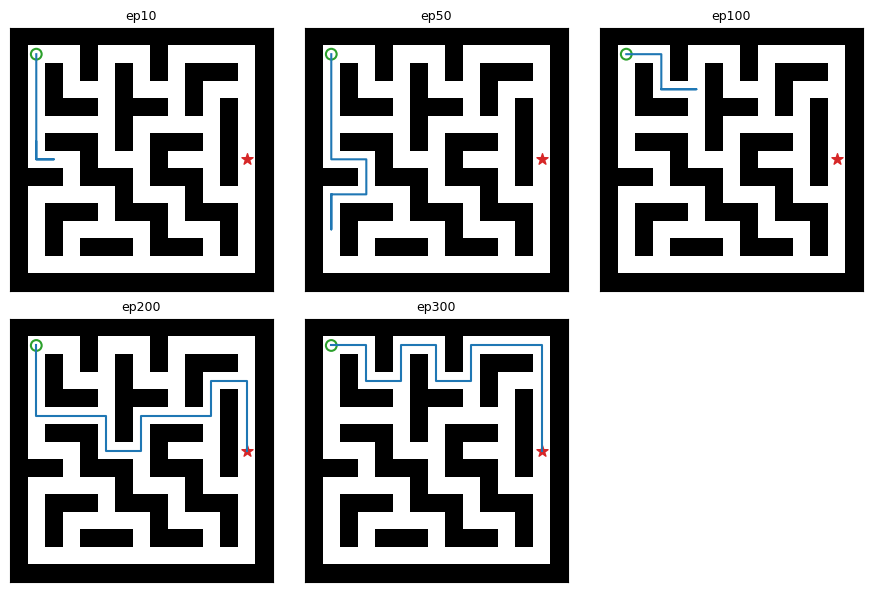

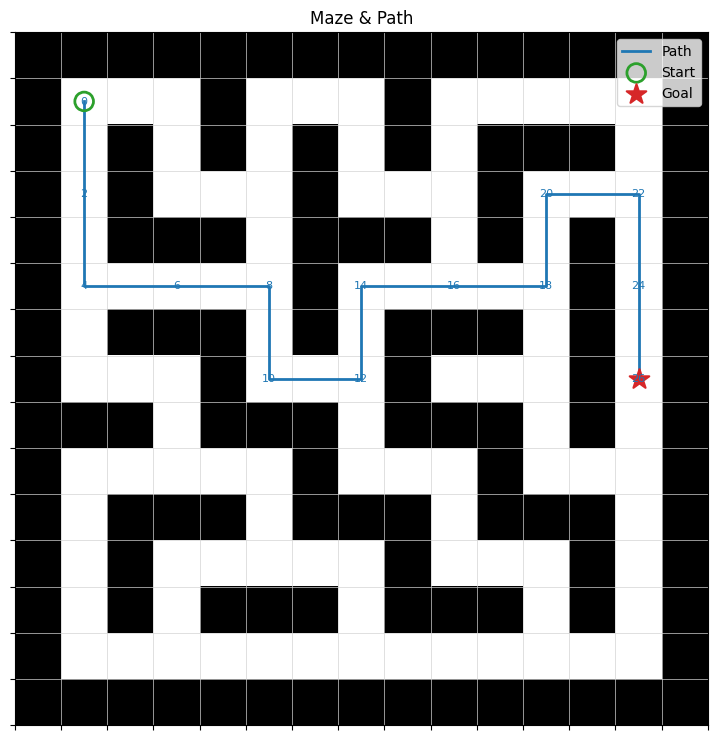

In [ ]:
# Fixed-maze shortest-path RL (Q-learning)
# pip install numpy

import numpy as np
from collections import deque
import matplotlib.pyplot as plt

rng = np.random.default_rng(0)

# ----- 1) 고정 미로 정의 (0: 빈칸, 1: 벽) -----
maze = np.array([
 [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],
 [1,0,0,0,1,0,0,0,1,0,0,0,0,0,1],
 [1,0,1,0,1,0,1,0,1,0,1,1,1,0,1],
 [1,0,1,0,0,0,1,0,0,0,1,0,0,0,1],
 [1,0,1,1,1,0,1,1,1,0,1,0,1,0,1],
 [1,0,0,0,0,0,1,0,0,0,0,0,1,0,1],
 [1,0,1,1,1,0,1,0,1,1,1,0,1,0,1],
 [1,0,0,0,1,0,0,0,1,0,0,0,1,0,1],
 [1,1,1,0,1,1,1,0,1,1,1,0,1,0,1],
 [1,0,0,0,0,0,1,0,0,0,1,0,0,0,1],
 [1,0,1,1,1,0,1,1,1,0,1,1,1,0,1],
 [1,0,1,0,0,0,0,0,1,0,0,0,1,0,1],
 [1,0,1,0,1,1,1,0,1,1,1,0,1,0,1],
 [1,0,0,0,0,0,0,0,0,0,0,0,0,0,1],
 [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],
], dtype=np.int8)

H, W = maze.shape
S = (1,1)    # 시작점
G = (7,13)  # 목표점

ACTIONS = [(0,-1),(0,1),(-1,0),(1,0)]  # 좌,우,상,하 (dx,dy)
nA = len(ACTIONS)

# ----- 2) 유틸: 상태 인덱스 변환 -----
def to_idx(p): return p[0]*W + p[1]
def to_xy(i): return (i//W, i%W)

free = [(r,c) for r in range(H) for c in range(W) if maze[r,c]==0]
nS = H*W

# ----- 3) 환경 동작: 벽이면 제자리, 목표 도달 시 종료 -----
def step(pos, a):
    dx, dy = ACTIONS[a]
    r, c = pos[0]+dy, pos[1]+dx
    if maze[r,c] == 1:  # 벽이면 이동 실패 → 제자리
        r, c = pos
    next_pos = (r,c)
    done = (next_pos == G)
    reward = 0.0 if done else -1.0  # 스텝당 -1, 목표 0 → 최단 경로 유도
    return next_pos, reward, done

# ----- 4) 참값: BFS 최단 거리 -----
def bfs_dist(start, goal):
    Q = deque([start]); dist = {start:0}
    while Q:
        u = Q.popleft()
        if u == goal: return dist[u]
        for a in range(nA):
            v,_r,_d = step(u,a)
            if v not in dist:
                dist[v] = dist[u]+(0 if v==u else 1)  # 벽이면 제자리(비용 0), 이동 시 1
                Q.append(v)
    return None

shortest = bfs_dist(S,G)
assert shortest is not None, "경로 없음"
# print(f"BFS shortest steps = {shortest}")

# ----- 5) Q-learning -----
gamma = 1.0          # 거리 최적화에 적합
alpha = 0.2
eps_start, eps_end = 1.0, 0.05
episodes = 500
max_steps = 500

Q = np.zeros((nS, nA), dtype=np.float32)

def eps_greedy(s, eps):
    if rng.random() < eps:
        return rng.integers(nA)
    return int(np.argmax(Q[s]))

# ----- 6) 학습 결과 경로 추출(탐욕 정책) 및 검증 -----
def greedy_path():
    pos = S
    path = [pos]
    visited = set([pos])
    for _ in range(2000):
        s = to_idx(pos)
        a = int(np.argmax(Q[s]))
        nxt, _, done = step(pos, a)
        if nxt == pos:  # 제자리 루프 방지 → 무작위 다른 행동 시도
            for aa in np.argsort(-Q[s]):  # 값 큰 순서로
                if aa == a: continue
                nxt2,_,_ = step(pos, int(aa))
                if nxt2 != pos:
                    nxt = nxt2; break
        pos = nxt
        path.append(pos)
        if pos == G: break
        if pos in visited:  # 루프 방지
            # 무작위 탈출
            for aa in range(nA):
                nxt2,_,_ = step(pos, aa)
                if nxt2 != pos:
                    pos = nxt2; path.append(pos); break
        visited.add(pos)
    return path

paths_by_ep = {}  # {episode: path}
for ep in range(1, episodes+1):
    pos = S
    eps = eps_end + (eps_start-eps_end)*np.exp(-ep/1000)  # 지수 감쇠
    for t in range(max_steps):
        s = to_idx(pos)
        a = eps_greedy(s, eps)
        nxt, r, done = step(pos, a)
        s2 = to_idx(nxt)
        td = r + gamma * (0.0 if done else np.max(Q[s2])) - Q[s,a]
        Q[s,a] += alpha * td
        pos = nxt
        if done: break

    # 1 에피소드마다 현재 greedy 정책 경로 저장
    if ep % 1 == 0:
        p = greedy_path()
        paths_by_ep[ep] = p  # 목표 미도달이어도 그대로 기록



path = greedy_path()
# 유효 경로 길이(이동만 카운트: 같은 칸 중복 제외)
move_steps = sum(path[i]!=path[i-1] for i in range(1,len(path)))
print(f"Greedy policy steps = {move_steps}, shortest = {shortest}")

assert path[-1]==G, "목표 미도달"
assert move_steps == shortest, "최단 경로 미달성(보상/학습 파라미터 조정 필요)"

# ----- 7) 결과 출력 -----
print("Path coordinates:")
print(path)

# === 에피소드별로 격자에 나눠 그리기(변화 과정 비교) ===
def plot_paths_grid(maze, S, G, paths_by_ep, episodes=None, ncols=5):
    import numpy as np
    import matplotlib.pyplot as plt
    if episodes is None:
        episodes = sorted(paths_by_ep.keys())
    n = len(episodes)
    nrows = (n + ncols - 1) // ncols

    H, W = maze.shape
    fig, axes = plt.subplots(nrows, ncols, figsize=(3*ncols, 3*nrows))
    axes = np.atleast_1d(axes).ravel()

    for ax, ep in zip(axes, episodes):
        path = paths_by_ep.get(ep, [])
        ax.imshow(maze, cmap="binary", interpolation="none", origin="upper")
        ax.set_xticks([]); ax.set_yticks([])
        ax.scatter([S[1]],[S[0]], s=60, marker="o", facecolors="none", edgecolors="tab:green", linewidths=1.5)
        ax.scatter([G[1]],[G[0]], s=70, marker="*", color="tab:red")
        if path:
            ys = [r for r, c in path]
            xs = [c for r, c in path]
            ax.plot(xs, ys, linewidth=1.5)
        ax.set_title(f"ep{ep}", fontsize=9)

    # 빈 축 숨기기
    for ax in axes[n:]:
        ax.axis("off")

    plt.tight_layout()
    plt.show()

def plot_maze_path(maze, path, S, G, annotate_steps=False, title="Maze & Path"):
    """maze: 0=빈칸, 1=벽
       path: [(r,c), ...]  (S→G)
       S,G : (r,c)
    """
    H, W = maze.shape
    fig, ax = plt.subplots(figsize=(max(5, W*0.6), max(5, H*0.6)))

    # 벽=검정, 빈칸=흰색
    ax.imshow(maze, cmap="binary", interpolation="none", origin="upper")

    # 격자선
    ax.set_xticks(np.arange(-0.5, W, 1))
    ax.set_yticks(np.arange(-0.5, H, 1))
    ax.grid(color="lightgray", linewidth=0.5)
    ax.set_xticklabels([])
    ax.set_yticklabels([])

    # 경로 라인 (셀 중심을 통과)
    ys = [r for r, c in path]
    xs = [c for r, c in path]
    ax.plot(xs, ys, linewidth=2, zorder=3, label="Path")

    # 시작(S), 목표(G)
    ax.scatter([S[1]],[S[0]], s=180, marker="o", facecolors="none",
               edgecolors="tab:green", linewidths=2, zorder=4, label="Start")
    ax.scatter([G[1]],[G[0]], s=220, marker="*", color="tab:red",
               linewidths=1.5, zorder=4, label="Goal")

    # 스텝 번호 주석(옵션)
    if annotate_steps:
        for i, (r, c) in enumerate(path):
            if i % 2 == 0:  # 빽빽함 방지: 2스텝마다 표시
                ax.text(c, r, str(i), ha="center", va="center",
                        fontsize=8, color="tab:blue", zorder=5)

    ax.set_title(title)
    ax.legend(loc="upper right")
    plt.show()

plot_paths_grid(maze, S, G, paths_by_ep, episodes=[10,50,100,200,300], ncols=3)
plot_maze_path(maze, path, S, G, annotate_steps=True)